Fundamental Analysis Trade Bot

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 70)

with open("stock_pickle_full.pickle", 'rb') as fp:
    stocks_df = pickle.load(fp)

Helper Functions to Assist Preprocessing

In [3]:
def setting_index(df):
    """
    Returns a sorted datetime index
    """
    df['Quarter end'] = pd.to_datetime(df['Quarter end'])
    df.set_index("Quarter end", inplace=True)
    return df.sort_index(ascending=True)
  
def class_creation(df, thres=3):
    """
    Creates classes of:
    - buy(1)
    - hold(2)
    - sell(0)
    
    Threshold can be changed to fit whatever price percentage change is desired
    """
    if df['Price high'] >= thres and df['Price low'] >= thres:
        # Buys
        return 1
    
    elif df['Price high'] <= -thres and df['Price low'] <= -thres:
        # Sells
        return 0
    
    else:
        # Holds
        return 2

Iterating through each Ticker to Transform the Data

In [4]:
# Setting the index as the Date
for i in tqdm(stocks_df.keys()):
    stocks_df[i] = setting_index(stocks_df[i])
    
# Replacing all "None" values with NaN
for i in tqdm(stocks_df.keys()):
    stocks_df[i].replace("None", 0, inplace=True)
    
# Creating a new dictionary that contains the numerical values, then converting all values to numeric values
num_df = {}
for i in tqdm(stocks_df.keys()):
    num_df[i] = stocks_df[i].apply(pd.to_numeric)
    
# Replacing values with percent difference or change
pcnt_df = {}
for i in tqdm(num_df.keys()):
    pcnt_df[i] = num_df[i].pct_change(periods=1).apply(lambda x: x*100)
    
# Replacing infinite values with NaN
for i in tqdm(pcnt_df.keys()):
    pcnt_df[i] = pcnt_df[i].replace([np.inf, -np.inf], np.nan)
    
# Creating a new DataFrame that contains the class 'Decision' determining if a quarterly reports improvement is a buy, hold, or sell.
new_df = {}
for i in tqdm(pcnt_df.keys()):
    # Assigning the new DF
    new_df[i] = pcnt_df[i]
    
    # Creating the new column with the classes, shifted by -1 in order to know if the prices will increase/decrease in the next quarter.
    new_df[i]['Decision'] = new_df[i].apply(class_creation, axis=1).shift(-1)
    
# Excluding the first and last rows
for i in tqdm(new_df.keys()):
    new_df[i] = new_df[i][1:-1]
    
# Combining all stock DFs into one
big_df = pd.DataFrame()
for i in tqdm(pcnt_df.keys()):
    big_df = big_df.append(new_df[i], sort=False)
    
# Filling the NaNs with 0
big_df.fillna(0, inplace=True)

# Resetting the index because we no longer need the dates
big_df.reset_index(drop=True, inplace=True)

# Dropping the price related columns to prevent data leakage
big_df.drop(['Price', 'Price high', 'Price low'], 1, inplace=True)

# Exporting the final DataFrame
with open("main_df.pkl", 'wb') as fp:
    pickle.dump(big_df, fp)

C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Alex Willett\Anacondaweed\lib\site-packages\ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Exploring the Data

In [5]:
with open("main_df.pkl", 'rb') as fp:
    final_df = pickle.load(fp)

Visualize the Count of our Classes

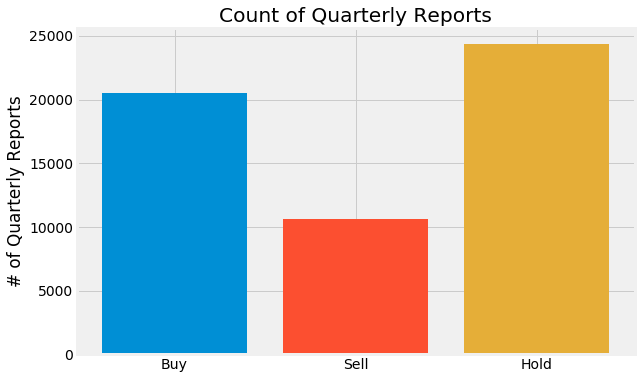

In [6]:
# Seperating each class into respective DataFrames
buy_df = final_df[final_df['Decision']==1].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
hold_df = final_df[final_df['Decision']==2].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
sell_df = final_df[final_df['Decision']==0].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)

# Visualizing in matplotlib
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# Plotting the count of each DataFrame of each class
plt.bar("Buy", buy_df.shape[0])
plt.bar("Sell", sell_df.shape[0])
plt.bar("Hold", hold_df.shape[0])

plt.ylabel('# of Quarterly Reports')
plt.title('Count of Quarterly Reports')
plt.show()

Correlation in Our Data

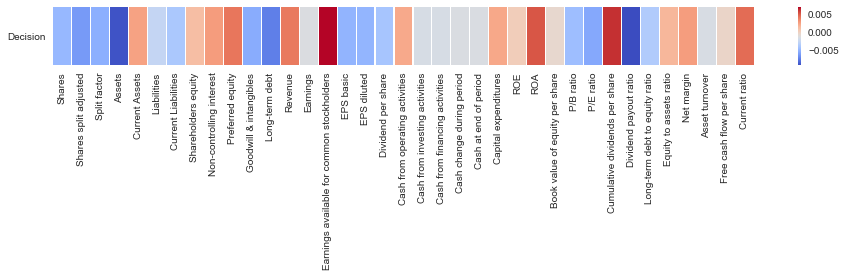

In [12]:
def CorrMtx(df, dropDuplicates = True):
    """
    Takes in a Correlation DF and excludes nonessential visuals.
    Creates a more visually pleasing correlation matrix
    """

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        
        
# Correlation DF of all classes
corr = final_df.corr().iloc[[-1],:-1]

# Plotting the Correlation DF as a heatmap
plt.figure(figsize=(14,1))
sns.heatmap(corr, annot=False, linewidths=.1, cmap="coolwarm")
plt.xticks()
plt.yticks(rotation=0)
plt.show()

Feature Engineering and Selection

Method # 1 Selecting the Top 10 Features based on Correlation Values

In [8]:
# Correlation DF of all classes
corr = final_df.corr().iloc[[-1],:-1]

# Sorting our Correlation DF by their absolute values and selecting the top 10
top10_corr = corr.transpose().apply(abs).sort_values(by='Decision', ascending=False)[:10]

# Creating a new DF with the features from the top10_corr and joing the 'Decision' class labels
top10_corr_df = final_df[top10_corr.index].join(final_df.Decision)

# Pickling the DF for use in our Classification models
with open("top10_corr_df.pkl", "wb") as fp:
    pickle.dump(top10_corr_df, fp)

Method #2: Selecting the Top 10 features based of Tree Classifier

In [9]:
# Instatiating the classifier
forest = ExtraTreesClassifier(n_estimators=200)

# Setting the corresponding variables for our classifier
X = final_df.drop(['Decision'], 1)
y = final_df.Decision

# Fitting the classifier
forest.fit(X, y)

# Determining the important features
importances = forest.feature_importances_

# The standard deviation among the trees for the important features
std = np.std([i.feature_importances_ for i in forest.estimators_], axis=0)

# Indexing and sorting the important features
indices = np.argsort(importances)[::-1]

# Assigning the top 10 features as a new DF
top10_df = final_df[X.columns[indices][:10]].join(final_df.Decision)

# Exporting the top 10 features DF
with open("top10_df.pkl", "wb") as fp:
    pickle.dump(top10_df, fp)

Feature Rankings:
1. P/B ratio: 0.042360006740268526
2. Assets: 0.031553966919356774
3. Shares split adjusted: 0.030672230113299007
4. Shares: 0.030210380735920483
5. P/E ratio: 0.030060483503745593
6. Asset turnover: 0.029723313646006395
7. Current Assets: 0.029584388071345637
8. Liabilities: 0.029428608112522427
9. Cash at end of period: 0.029418521635616566
10. Revenue: 0.029164871300878577


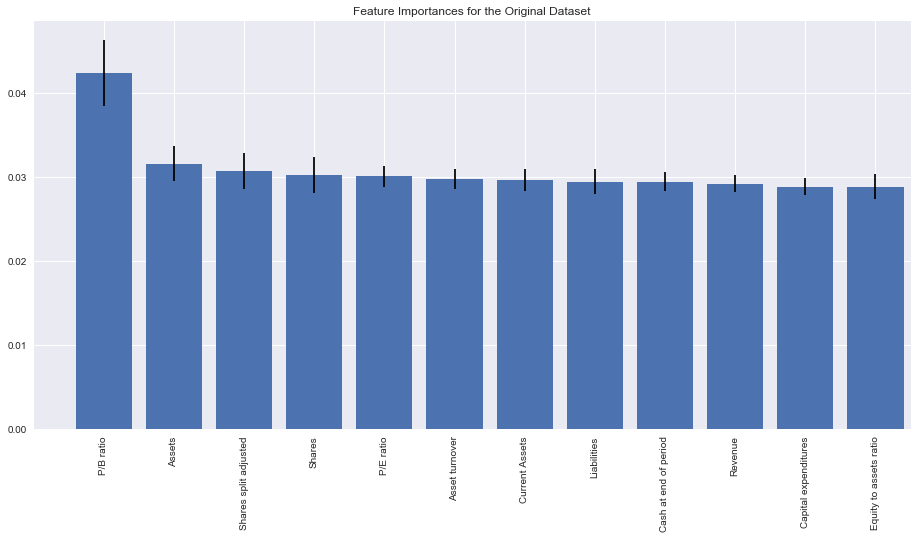

In [10]:

# Matplotlib style to use
plt.style.use('seaborn')

# Printing out the different features as a list
print("Feature Rankings:")

# Showing the top 10 features
for i in range(10):
    print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]}")
    
# Plotting the top 10 features
plt.figure(figsize=(14,7))

plt.title("Feature Importances for the Original Dataset")
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align='center')

plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, 11.5])
plt.show()

In [ ]:
Fa